# Fit $\rm CsErSe_2$ to a point charge model, and then fit the CEF coefficients directly

Allen Scheie

November 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import sys

cpal1 = plt.cm.Set1(np.arange(9))
import PyCrystalField as cef
from pythonlib.MsliceData import mslice

In [26]:
## Import all the data

datadirectory = 'CES_CEF_data/'

cutlist =   ['CES_100K_9meV',            'CES_2K_9meV',
            'CES_50K_9meV',            'CES_2K_9meV_3T',
            'CES_2K_9meV_5T',            'CES_2K_9meV_0T',
            'CES_2K_9meV_1T',            'CES_2K_9meV_2T',
            'CES_2K_9meV_0Tb',    'CES_2K_30meV']

ProtonCharges = [7.97, 8*3, 8*3+5.61, 8+6.59, 5.07, 2, 4,4,1.13, 8*4+5.1]  
# The proton charge doesn't seem to correct the normalization problem.
# Rather, the sample seems to have decreased in intensity post-5T field...
# See the cell below where I derive the scale factor.
scalefactor = 1.66582869
Norm = [scalefactor, 1,1, scalefactor, scalefactor, scalefactor, 
        scalefactor, scalefactor, scalefactor, scalefactor,]

DATA = {}
for i,cn in enumerate(cutlist):
    DATA[cn] = mslice(datadirectory+cn)
    DATA[cn].normalize(1e3*Norm[i])

In [3]:
ll, ul = 160, 260
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0T'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleA, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0Tb'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleB, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
print((pscaleA+pscaleB)/2)

scalevalue = np.mean([pscaleA, pscaleB])

[1.]


# Plot zero-field data

<IPython.core.display.Javascript object>


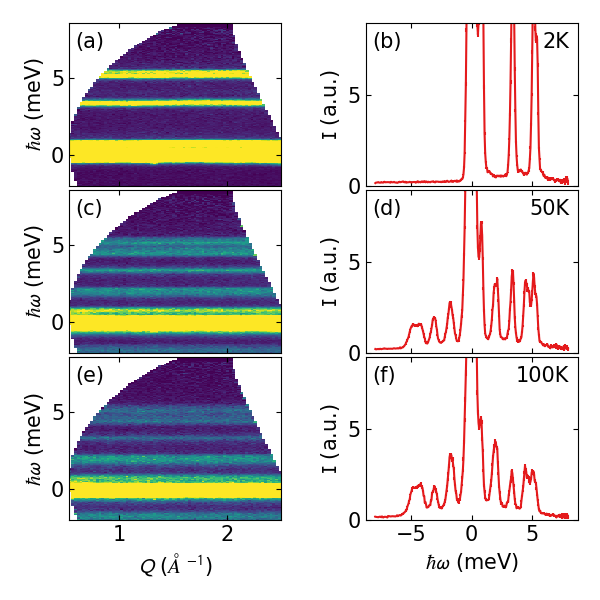

In [4]:
ZFcutlist =   ['CES_2K_9meV', 'CES_50K_9meV', 'CES_100K_9meV']

f, ax = plt.subplots(3,2, figsize=(6,6))
for i in range(2):
    plt.setp(ax[i,0].get_xticklabels(), visible=False)
    plt.setp(ax[i,1].get_xticklabels(), visible=False)

for i in range(len(ax)):
    data = DATA[ZFcutlist[i]]
    ax[i,0].pcolormesh(data.sx, data.sy, data.si, vmin=0, vmax=8)
    ax[i,1].errorbar( data.cx, data.ci, data.ce)
    ax[i,1].set_ylim(0,9)
    # Label temperature
    templabel = ZFcutlist[i].split('_')[1]
    ax[i,1].text(0.96,0.94, templabel, verticalalignment='top', horizontalalignment='right',
                 transform=ax[i,1].transAxes)
    # Label y axis
    ax[i,0].set_ylabel('$\\hbar \\omega$ (meV)')
    ax[i,1].set_ylabel('$\\rm I$ (a.u.)')
    
subplotlabels = 'abcdefg'
for i, axes in enumerate(ax.flatten()):
    axes.text(0.03,0.94, '('+subplotlabels[i]+')', verticalalignment='top', 
              horizontalalignment='left', transform=axes.transAxes)
    
ax[-1,0].set_xlabel('$Q$ ($\\AA^{-1}$)')
ax[-1,1].set_xlabel('$\\hbar \\omega$ (meV)')
    
plt.tight_layout()
f.subplots_adjust(hspace=0.02, wspace=0.4)

# Fit point charge model

In [5]:
SeEr = 2.8638  #distance from Se to Er in \AA
caxis  = 16.5798
abaxis = 4.1799
abPlaneDist = (1/3*np.array([1, 0]) + 2/3*np.array([-1/2, np.sqrt(3)/2]))*abaxis
print(np.linalg.norm(abPlaneDist))
print('z=',np.sqrt(SeEr**2 - np.linalg.norm(abPlaneDist)**2), '\AA')
print('z=',np.sqrt(SeEr**2 - np.linalg.norm(abPlaneDist)**2)/caxis, 'RLU')

2.4132663901857168
z= 1.5419130228388365 \AA
z= 0.09299949473689892 RLU


In [6]:
############## Build point charge model to make initial estimate
Erpos = np.array([0.0, 0.0, 0.0])

zSe = 0.42633
Sepos = np.array([[0.66667,  0.33333, 1/3 - zSe],
                [-0.33333,  0.33333,  1/3 - zSe],
                [-0.33333, -0.66667,  1/3 - zSe],
                [-0.66667, -0.33333, -1/3 + zSe],
                [ 0.33333, -0.33333, -1/3 + zSe],
                [ 0.33333,  0.66667, -1/3 + zSe]])

ErLig = cef.Ligands(ion = 'Er3+',
    latticeParams=[4.1799,  4.1799, 16.5798,  90.0000,  90.0000, 120.0000],
    ionPos= Erpos, ligandPos=Sepos)

print(np.linalg.norm(ErLig.bonds[0]))
# Rotate so that y axis is along mirror plane
ErLig.rotateLigandsZ(oldaxis=ErLig.bonds[0])

Er3 = ErLig.PointChargeModel(printB = True, suppressminusm=True)
Er3.diagonalize()
Er3.printEigenvectors()
Er3.gsExpectation()

2.8637849235065005
B_2 0  =  -0.06010949
B_2 1  =  9.73e-06
B_2 2  =  -8.72e-06
B_4 0  =  -0.00023513
B_4 1  =  -0.0
B_4 2  =  -2e-08
B_4 3  =  -0.00769844
B_4 4  =  1e-08
B_6 0  =  7.8e-07
B_6 1  =  -0.0
B_6 2  =  0.0
B_6 3  =  -2.15e-06
B_6 4  =  -0.0
B_6 5  =  0.0
B_6 6  =  6.98e-06

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.966  0.     0.    -0.245 -0.    -0.     0.08   0.     0.     0.015
  0.     0.     0.001  0.     0.     0.   ]  |
0.00000 	|  [ 0.    -0.     0.    -0.001  0.    -0.     0.015 -0.     0.    -0.08
 -0.     0.    -0.245 -0.     0.    -0.966]  |
4.10584 	|  [-0.     0.705  0.037  0.    -0.385 -0.067 -0.     0.185  0.123  0.
  0.101  0.256  0.     0.055  0.469 -0.   ]  |
4.10584 	|  [ 0.     0.469 -0.055  0.    -0.256  0.101 -0.     0.123 -0.185 -0.
  0.067 -0.385 -0.     0.037 -0.705 -0.   ]  |
6.94502 	|  [-0.    -0.241 -0.092 -0.    -0.047  

In [7]:
## Define data
alldata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_50K_9meV']]
datatemps = [1.8, 50]

<IPython.core.display.Javascript object>


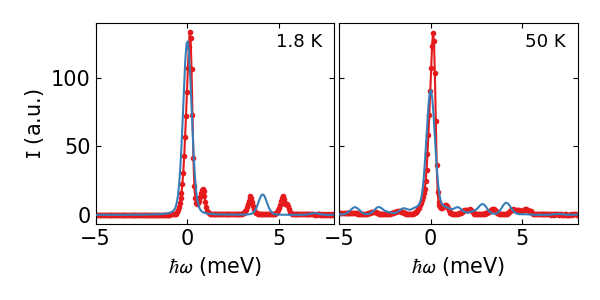

In [8]:
# Try overplotting initial simulation just for kicks
xxx = np.linspace(-10,30,600)

fig2, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
for i,data in enumerate(alldata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.')
    ax[i].set_xlim(-5,8)
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')

    ax[i].plot(xxx, 1.5*Er3.neutronSpectrum(Earray=xxx,Temp=datatemps[i],  Ei=9, 
                                            ResFunc=lambda x: 0.5,  gamma=0.09), zorder=10)
    
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
fig2.subplots_adjust(wspace=0.02)

### Fit observed transitions to pull out eigenvalues

<IPython.core.display.Javascript object>


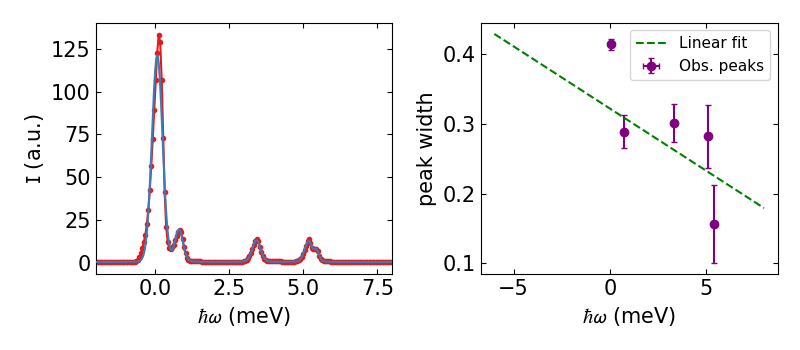

[0.07517211974600753, 0.7310563754703909, 3.3430389113350087, 5.0971456786049085, 5.377777212698675] [0.4132660062508849, 0.288638322840261, 0.3005368004446522, 0.2815966433551471, 0.1566254770893106] 0.050394384987051934
[-0.01778629  0.32154258]


In [9]:
## Pick out observed eigenvalues
from scipy.special import wofz

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0].cx, alldata[0].ci, alldata[0].ce

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.45

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.45

p0 = [56, 0.15,0.27, 8,0.67,0.25, 5,3.27,0.25, 3,5.0,0.10, 2,5.25,0.10, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]

## Adjust the measured observed width so it matches the peak (not perfectly Gaussian...)
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
# ax[1].plot(xxx, resfunc(xxx), color='red', ls='--', label = "Ovi's res. func.")
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

<IPython.core.display.Javascript object>


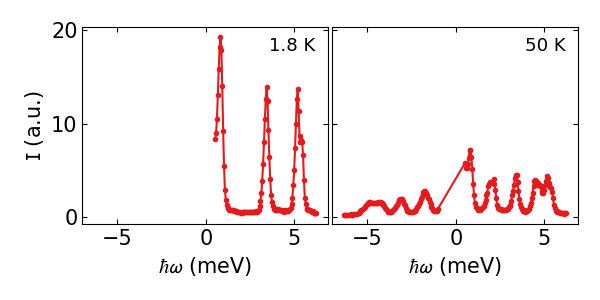

In [10]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i].cx = np.hstack((fitdata[i].cx[20:120], fitdata[i].cx[150:265]))
    fitdata[i].ci = np.hstack((fitdata[i].ci[20:120], fitdata[i].ci[150:265]))
    fitdata[i].ce = np.hstack((fitdata[i].ce[20:120], fitdata[i].ce[150:265]))
    
fitdata[0].cx = fitdata[0].cx[100:]
fitdata[0].ci = fitdata[0].ci[100:]
fitdata[0].ce = fitdata[0].ce[100:]
    
f, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

In [11]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]


######################

xoffset = ObsEnergies[0]+0.06
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def bkg(iii, x):
    if iii == 0:
        return gaus(x, 2, 3.5, 2.5) + 0.2  + gaus(x, 7, 0.1, 0.25)
    else:
        return gaus(x, 6.5, 1.5, 5) + 0.1  + gaus(x, 7, 0.1, 0.25)

def err_global_PC(CFLevelsObject, zSe, distSe, gamma, pref):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    Sepos = np.array([[0.66667,  0.33333, 1./3 - zSe],
                    [-0.33333,  0.33333,  1./3 - zSe],
                    [-0.33333, -0.66667,  1./3 - zSe],
                    [-0.66667, -0.33333, -1./3 + zSe],
                    [ 0.33333, -0.33333, -1./3 + zSe],
                    [ 0.33333,  0.66667, -1./3 + zSe]])*distSe

    ErLig = cef.Ligands(ion = 'Er3+',
        latticeParams=[4.1470,  4.1470, 22.7662,  90.0000,  90.0000, 120.0000],
        ionPos= Erpos, ligandPos=Sepos)

    ## Rotate so that y axis is along mirror plane
    ErLig.rotateLigandsZ(oldaxis=ErLig.bonds[0])
    ErFit = ErLig.PointChargeModel(printB = False, suppressminusm=True)
    ErFit.diagonalize()

    # Compute error in eigenvalue
    try: erro=np.nansum((ErFit.eigenvalues.real - np.repeat(ObservedEnergies,2))**2)*4e5
    except TypeError:  erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* ErFit.neutronSpectrum(Earray=data.cx-xoffset,Temp=datatemps[i],  Ei=9, 
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gamma) )+\
                bkg(i, data.cx) - data.ci
        if i == 0:
            erro += np.nansum((errspec/data.ce)**2)*2  # Chisq with uncertainty
            # Best fit was with multiplication by 3
        else:
            erro += np.nansum((errspec/data.ce)**2)



    #return err0 + constraint
    sys.stdout.write("\r err = "+str(erro))
    sys.stdout.flush() # important for printing progress
    return erro

## Test function
err_global_PC(10, zSe=0.2649, distSe=1.0, gamma=0.01, pref=1.5)

 err = 29634988.937783238

29634988.937783238

In [12]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes1 = Er3.fitdata(chisqfunc = err_global_PC,  fitargs = ['zSe', 'distSe','pref'], method = 'Nelder-Mead',
            zSe=0.42633, distSe=1.0, gamma=fittedLW, pref=0.59)
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 1623537.48040102331623537.4804010233
 err = 35414479.9407656935414479.94076569
Initial err = 35414479.94076569 	Final err = 1623537.4804010233


In [13]:
print(FitCoefRes1['zSe'], FitCoefRes1['distSe'], FitCoefRes1['pref'])

[0.40645213] [0.9345473] [0.08892834]


In [14]:
Sepos = np.array([[0.66667,  0.33333, 1./3 - FitCoefRes1['zSe']],
                [-0.33333,  0.33333,  1./3 - FitCoefRes1['zSe']],
                [-0.33333, -0.66667,  1./3 - FitCoefRes1['zSe']],
                [-0.66667, -0.33333, -1./3 + FitCoefRes1['zSe']],
                [ 0.33333, -0.33333, -1./3 + FitCoefRes1['zSe']],
                [ 0.33333,  0.66667, -1./3 + FitCoefRes1['zSe']]])*FitCoefRes1['distSe']

ErLigFit = cef.Ligands(ion = 'Er3+',
    latticeParams=[4.1470,  4.1470, 22.7662,  90.0000,  90.0000, 120.0000],
    ionPos= Erpos, ligandPos=Sepos)

## Rotate so that y axis is along mirror plane
ErLigFit.rotateLigandsZ(oldaxis=ErLigFit.bonds[0])
ErCoefFit1 = ErLigFit.PointChargeModel(printB = True, suppressminusm=True)

ErCoefFit1.diagonalize()
ErCoefFit1.printEigenvectors()
ErCoefFit1.gsExpectation()

B_2 0  =  -0.01198649
B_2 1  =  1.031e-05
B_2 2  =  -9.12e-06
B_4 0  =  -0.00033455
B_4 1  =  1e-08
B_4 2  =  -3e-08
B_4 3  =  -0.00967434
B_4 4  =  1e-08
B_6 0  =  9e-07
B_6 1  =  -0.0
B_6 2  =  0.0
B_6 3  =  -9.26e-06
B_6 4  =  -0.0
B_6 5  =  0.0
B_6 6  =  8.45e-06

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.823  0.     0.    -0.436 -0.    -0.     0.359  0.     0.     0.064
  0.     0.     0.002 -0.     0.    -0.002]  |
0.00000 	|  [-0.002 -0.    -0.    -0.002  0.    -0.     0.064 -0.     0.    -0.359
 -0.     0.    -0.436 -0.     0.    -0.823]  |
0.85621 	|  [-0.    -0.059  0.155  0.     0.076 -0.347 -0.    -0.106  0.675  0.
 -0.054  0.483  0.    -0.024  0.377  0.   ]  |
0.85621 	|  [ 0.    -0.377 -0.024 -0.     0.483  0.054  0.    -0.675 -0.106  0.
 -0.347 -0.076  0.    -0.155 -0.059  0.   ]  |
4.16513 	|  [-0.001 -0.488 -0.1   -0.     0.292  0.125  0.002  0.04

<IPython.core.display.Javascript object>


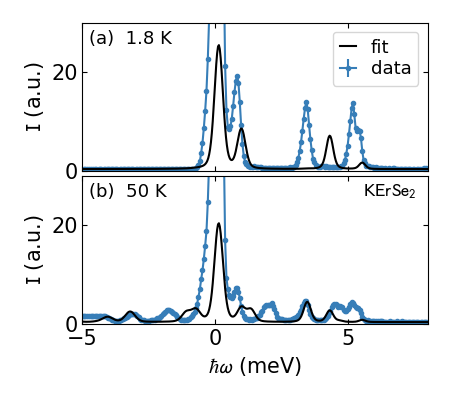

In [15]:
# Try overplotting initial simulation just for kicks
xxx = np.linspace(-10,30,1200)

fig2, ax = plt.subplots(2,1, figsize=(4.5,4), sharex=True, sharey=True)
for i,data in enumerate(alldata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.', label='data', color=cpal1[1])
    ax[i].set_xlim(-5,8)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
    ax[i].set_ylabel('$\\rm I$ (a.u.)')

    ax[i].plot(xxx, (0.3*ErCoefFit1.neutronSpectrum(Earray=xxx-xoffset,Temp=datatemps[i],  Ei=9, 
                                    ResFunc= lambda de: straightline(de, *width_popt),  gamma=0.1) + 0.3),
              color='k', zorder=10, label='fit')
    
ax[0].set_ylim(-0.1,30)
ax[0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)
    
subplotlabels = 'abcdefghijk'
for i, axx in enumerate(ax):
    axx.text(0.02,0.95, '('+subplotlabels[i]+')  '+str(datatemps[i])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left', fontsize=13)
    
ax[-1].text(0.97,0.95, '$\\rm KErSe_2$', transform=ax[-1].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    
plt.tight_layout()
fig2.subplots_adjust(hspace=0.03)

## Fit again, this time directly to the coefficients

In [16]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]

# Take final ligand values from above
Coefficients = []

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        print(n,m, ErLigFit.B[i])
        Coefficients.append(ErLigFit.B[i])
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

        
Er = cef.CFLevels(Er_O, Coefficients)
Er.diagonalize()

######################

xoffset = ObsEnergies[0]+0.05
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def err_global(CFLevelsObject, coeff, gamma, pref):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    # Compute error in eigenvalue
    try: erro=np.nansum((CFLevelsObject.eigenvalues.real - np.repeat(ObservedEnergies,2))**2)*1.0e5
    except TypeError:  erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx-xoffset,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gamma) )+\
                bkg(i, data.cx) - data.ci
        if i == 0:
            erro += np.nansum((errspec/data.ce)**2)#*2  # Chisq with uncertainty
        else:
            erro += np.nansum((errspec/data.ce)**2)


    #return err0 + constraint
    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

2 0 -0.01198649114696912
4 0 -0.0003345471506331775
4 3 -0.00967434297091081
6 0 8.981609980705139e-07
6 3 -9.264930183918987e-06
6 6 8.452844247902009e-06


In [17]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes2 = Er.fitdata(chisqfunc = err_global,  fitargs = ['coeff','pref'], 
                         method = 'Powell',
            coeff = Coefficients, gamma=fittedLW, pref=0.3)
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 12878.277963211174        12878.277963211174
 err = 828769.0872239444    828769.0872239444
Initial err = 828769.0872239444 	Final err = 12878.277963211174


#### Fit again
but we kick the fit out of the local minimum by multiplying the fitted prefactor by 10

In [18]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes3 = Er.fitdata(chisqfunc = err_global,  fitargs = ['coeff','pref'], 
                         method = 'Nelder-Mead',
            coeff = FitCoefRes2['coeff'], gamma=fittedLW, pref=FitCoefRes2['pref']*10)
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 10267.981995757495    10267.981995757495
 err = 24082336.601892367    24082336.601892367
Initial err = 24082336.601892367 	Final err = 10267.981995757495


In [19]:
## Redefine chi2 function, lessen weight on eigenvalues

xoffset = ObsEnergies[0]+0.05
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def err_global(CFLevelsObject, coeff, gamma, pref):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    # Compute error in eigenvalue
    try: erro=np.nansum((CFLevelsObject.eigenvalues.real - np.repeat(ObservedEnergies,2))**2)*5e4
    except TypeError:  erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx*(1+datatemps[i]*1e-4)-xoffset,
                                                                  Temp=datatemps[i], # Ei=9, 
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gamma) )+\
                bkg(i, data.cx) - data.ci
        if i == 0:
            erro += np.nansum((errspec/data.ce)**2)#*2  # Chisq with uncertainty
        else:
            erro += np.nansum((errspec/data.ce)**2)


    #return err0 + constraint
    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

# For reference,
ErCoefFit1 = cef.CFLevels(Er_O, FitCoefRes3['coeff'])
err_global(ErCoefFit1, coeff = FitCoefRes3['coeff'], gamma=fittedLW, pref=FitCoefRes3['pref'])

 err = 7564.747762696188    

7564.747762696188

In [20]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes4 = Er.fitdata(chisqfunc = err_global,  fitargs = ['coeff','pref'], 
                         method = 'Powell',
            coeff = FitCoefRes3['coeff'], gamma=fittedLW, pref=FitCoefRes3['pref'])
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 7532.037275905047         7532.037275905047
 err = 7564.747762696188    7564.747762696188
Initial err = 7564.747762696188 	Final err = 7532.037275905047


In [21]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes5 = Er.fitdata(chisqfunc = err_global,  fitargs = ['coeff','pref'], 
                         method = 'Nelder-Mead',
            coeff = FitCoefRes4['coeff'], gamma=fittedLW, pref=FitCoefRes4['pref']*10)
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 7531.934886011658     7531.934886011658
 err = 24309026.872157175    24309026.872157175
Initial err = 24309026.872157175 	Final err = 7531.934886011658


## Fit xoffset and temperature dependent gamma

In [22]:
def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                bkg(i, data.cx) - data.ci
        erro += np.nansum((errspec/data.ce)**2)


    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

In [23]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes6 = Er.fitdata(chisqfunc = err_global_final,  fitargs = ['coeff','pref','gammas','xoff'], 
                         method = 'Nelder-Mead',
            coeff = FitCoefRes5['coeff'], gammas=[fittedLW,fittedLW], pref=FitCoefRes5['pref'], 
                         xoff = 0.05)#, #therm = 1e-4)
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 5842.483791662742     5842.483791662742
 err = 42249.767109725435    42249.767109725435
Initial err = 42249.767109725435 	Final err = 5842.483791662742


In [24]:
print(FitCoefRes6)

ErCoefFit1 = cef.CFLevels(Er_O, FitCoefRes6['coeff'])
ErCoefFit1.diagonalize()
ErCoefFit1.printEigenvectors()
ErCoefFit1.gsExpectation()
ErCoefFit1.gtensor()

{'coeff': array([-3.60740328e-02, -3.82694983e-04, -1.38959810e-02,  3.15219896e-06,
       -4.36048862e-06,  3.36282008e-05]), 'pref': array([0.42646004]), 'gammas': array([0.06171637, 0.06374596]), 'xoff': array([0.12768043]), 'Chisq': 5842.483791662742}

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.587  0.012  0.    -0.51  -0.032  0.     0.509  0.049  0.
  0.334  0.049  0.     0.123  0.056  0.   ]  |
0.00000 	|  [ 0.     0.056 -0.123  0.    -0.049  0.334  0.     0.049 -0.509  0.
  0.032 -0.51   0.     0.012 -0.587  0.   ]  |
0.67545 	|  [ 0.     0.     0.     0.033  0.     0.    -0.223 -0.     0.     0.361
 -0.     0.     0.463  0.     0.     0.777]  |
0.67545 	|  [ 0.777  0.     0.    -0.463  0.     0.     0.361  0.     0.     0.223
  0.     0.     0.033  0.     0.     0.   ]  |
3.28591 	|  [ 0.     0.671  0.004  0.    -0.038  0.024  0.    -0.706 -0.096  0

array([[-5.41404094,  0.        ,  0.        ],
       [ 0.        ,  5.41404094,  0.        ],
       [ 0.        ,  0.        ,  5.89211193]])

<IPython.core.display.Javascript object>


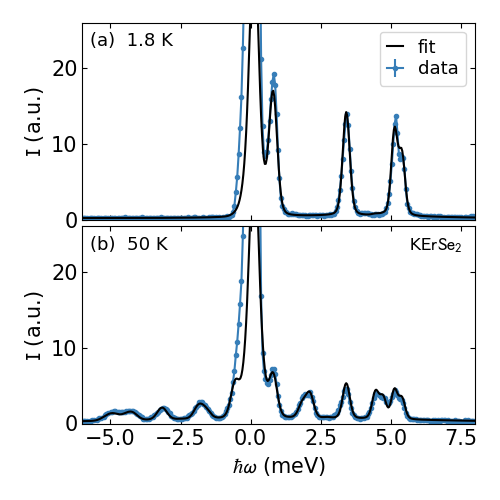

In [25]:
# Plot final fit
xxx = np.linspace(-10,30,1200)

fig2, ax = plt.subplots(2,1, figsize=(5,5), sharex=True, sharey=True)
for i,data in enumerate(alldata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.', label='data', color=cpal1[1])
    ax[i].set_xlim(-6,8)
    ax[i].set_ylabel('$\\rm I$ (a.u.)')

    ax[i].plot(xxx, (FitCoefRes6['pref']*ErCoefFit1.normalizedNeutronSpectrum(
                Earray=xxx*(1-datatemps[i]*0)-FitCoefRes6['xoff'],
                             Temp=datatemps[i], ResFunc=lambda de: straightline(de, *width_popt), 
                            gamma=FitCoefRes6['gammas'][i]) + bkg(i, xxx)),
                            # gamma = fittedLW) + bkg(i, xxx)),
              color='k', zorder=10, label='fit')
    
ax[0].set_ylim(-0.1,26)
ax[0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)
    
subplotlabels = 'abcdefghijk'
for i, axx in enumerate(ax):
    axx.text(0.02,0.95, '('+subplotlabels[i]+')  '+str(datatemps[i])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left', fontsize=13)
    
ax[-1].text(0.97,0.95, '$\\rm KErSe_2$', transform=ax[-1].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
ax[-1].set_xlabel('$\\hbar \\omega$ (meV)')
    
plt.tight_layout()
fig2.subplots_adjust(hspace=0.03)

## Thus, the initial fit is completed. It looks pretty good. The next step in the fit is CES_CEF_fit2.ipynb, where we compare this fit to the result from $\rm KErSe_2$